In [17]:
import sys
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from rnn import RNN
import torch
import torch.nn.functional as F
import tqdm
from torch import matmul, sigmoid, tanh
import pandas as pd

sns.set_style("whitegrid")

BANDS = ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9']

# simulate no GPU (for checks like torch.cuda.is_available())
os.environ["CUDA_VISIBLE_DEVICES"] = ""

csvdir = "/home/marc/projects/ISPRS_CropTypeMapping/images/backprop"

In [2]:
sys.path.append("../src")
from datasets.BavarianCrops_Dataset import BavarianCropsDataset
from argparse import Namespace

#args = Namespace(classmapping='/data/GAFdataset/classmapping.isprs.csv', mode=None, partition='test', region='holl', root='/data/BavarianCrops', samplet=70, scheme='blocks', seed=0)

ds = BavarianCropsDataset(classmapping='/data/GAFdataset/classmapping.isprs.csv', mode=None, partition='test', region='holl', root='/data/BavarianCrops', samplet=70, scheme='blocks', seed=0)

i = 0
for i in range(50):
    x,y,meta = ds[i]

    data_root = "/data/isprs/backprop/data"

    np.save(os.path.join(data_root,f"{meta}_x.npy"),x)
    np.save(os.path.join(data_root,f"{meta}_y.npy"),y)

Initializing BavarianCropsDataset test partition in holl
read 23 classes
precached dataset files found at /data/BavarianCrops/npy/classmapping.isprs.csv/blocks/holl/test
loaded 9792 samples
Dataset /data/BavarianCrops. region holl. partition test. X:9792x(144, 13), y:(9792,) with 23 classes


In [154]:
def load(fid):
    root = "/data/isprs/backprop/data/"
    x = np.load(os.path.join(root,f"{fid}_x.npy"))
    y = np.load(os.path.join(root,f"{fid}_y.npy"))
    return x,y 
ids = [71459194,71459842,71459872,71460046]

meta = ids[3]
x,y = load(meta)


def totorch(x):
     return torch.Tensor(x).unsqueeze(0)#.transpose(1,2)

    
def save_csv(arr,fname):
    os.makedirs(os.path.dirname(fname),exist_ok=True)
    df = pd.DataFrame(arr, columns=BANDS)
    df.index.name="t"
    df.to_csv(fname)
    print(f"writing {fname}")

In [155]:
print(ds.classname[y[0]])

corn


## Transformer

In [136]:
sys.path.append("../src/models")
from TransformerEncoder import TransformerEncoder

hidden_dims = 64
n_heads = 7
n_layers = 8
dropout=0.120580263977179
d_inner = hidden_dims*4
nclasses=23

transformer = TransformerEncoder(in_channels=13, len_max_seq=70,
            d_word_vec=hidden_dims, d_model=hidden_dims, d_inner=d_inner,
            n_layers=n_layers, n_head=n_heads, d_k=hidden_dims//n_heads, d_v=hidden_dims//n_heads,
            dropout=dropout, nclasses=nclasses)

# set transformer to eval mode
transformer.zero_grad()
transformer.eval()
_ = transformer.load("/data/isprs/backprop/transformer.pth")

model = transformer

loading model from /data/isprs/backprop/transformer.pth


/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

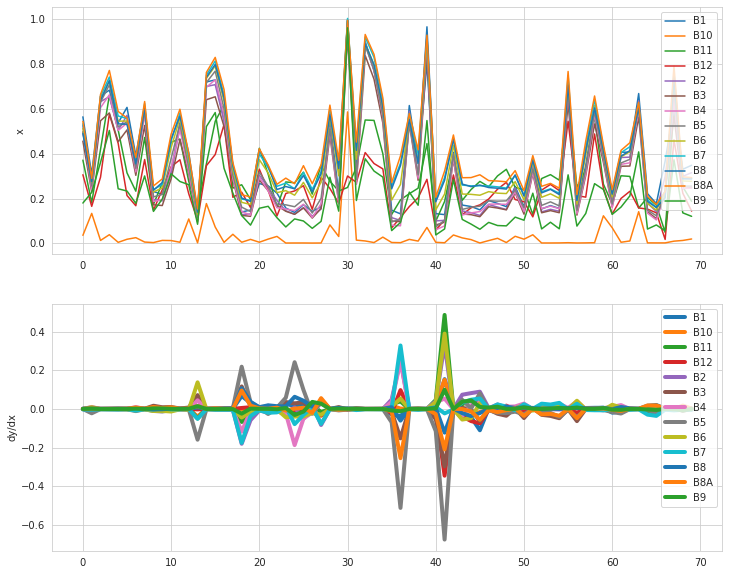

In [137]:
x_with_grad = torch.autograd.Variable(totorch(x).transpose(1,2), requires_grad=True)
logprobabilities = model.forward(x_with_grad)
maxypred = logprobabilities.exp().max()
maxypred.backward()
dydx = x_with_grad.grad

fig, axs = plt.subplots(2, figsize=(12,10))
axs[0].plot(x_with_grad[0].detach().numpy().T)
axs[0].set_ylabel("x")
axs[0].legend(BANDS)
axs[1].plot(x_with_grad.grad[0].numpy().T,linewidth=4)
axs[1].set_ylabel("dy/dx")
axs[1].legend(BANDS)

In [138]:
fname=os.path.join(csvdir, "transformer", str(meta), "dydx.csv")
save_csv(dydx.numpy()[0].T,fname)
fname=os.path.join(csvdir,"transformer", str(meta), f"x.csv")
save_csv(x,fname)

writing /home/marc/projects/ISPRS_CropTypeMapping/images/backprop/transformer/71460046/dydx.csv
writing /home/marc/projects/ISPRS_CropTypeMapping/images/backprop/transformer/71460046/x.csv


In [139]:
from rnn import RNN
from models.multi_scale_resnet import MSResNet
from TempCNN import TempCNN

model = RNN(input_dim=13, nclasses=23, hidden_dims=16, num_rnn_layers=6, dropout=0.294243177060266, bidirectional=True)
_ = model.load("/data/isprs/backprop/rnn.pth")

loading model from /data/isprs/backprop/rnn.pth


writing /home/marc/projects/ISPRS_CropTypeMapping/images/backprop/rnn/71460046/dydx.csv
writing /home/marc/projects/ISPRS_CropTypeMapping/images/backprop/rnn/71460046/x.csv


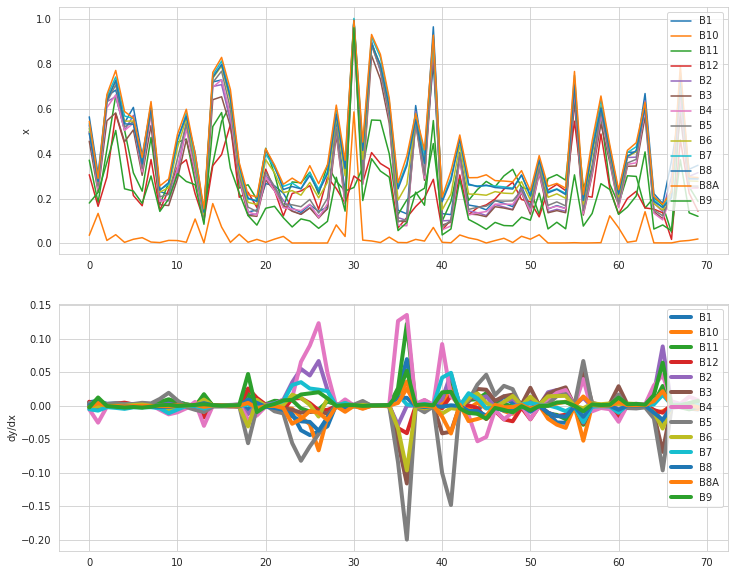

In [140]:
x_with_grad = torch.autograd.Variable(totorch(x), requires_grad=True)
logprobabilities = model.forward(x_with_grad)
maxypred = logprobabilities.exp().max()
maxypred.backward()
dydx = x_with_grad.grad

fig, axs = plt.subplots(2, figsize=(12,10))
axs[0].plot(x_with_grad[0].detach().numpy())
axs[0].set_ylabel("x")
axs[0].legend(BANDS)
axs[1].plot(x_with_grad.grad[0].numpy(),linewidth=4)
axs[1].set_ylabel("dy/dx")
axs[1].legend(BANDS)

fname=os.path.join(csvdir, "rnn", str(meta), "dydx.csv")
save_csv(dydx.numpy()[0],fname)
fname=os.path.join(csvdir,"rnn", str(meta), f"x.csv")
save_csv(x,fname)

In [141]:
model = MSResNet(input_channel=13, layers=[1, 1, 1, 1], num_classes=23)
_ = model.load("/data/isprs/backprop/msresnet.pth")

loading model from /data/isprs/backprop/msresnet.pth


writing /home/marc/projects/ISPRS_CropTypeMapping/images/backprop/msresnet/71460046/dydx.csv
writing /home/marc/projects/ISPRS_CropTypeMapping/images/backprop/msresnet/71460046/x.csv


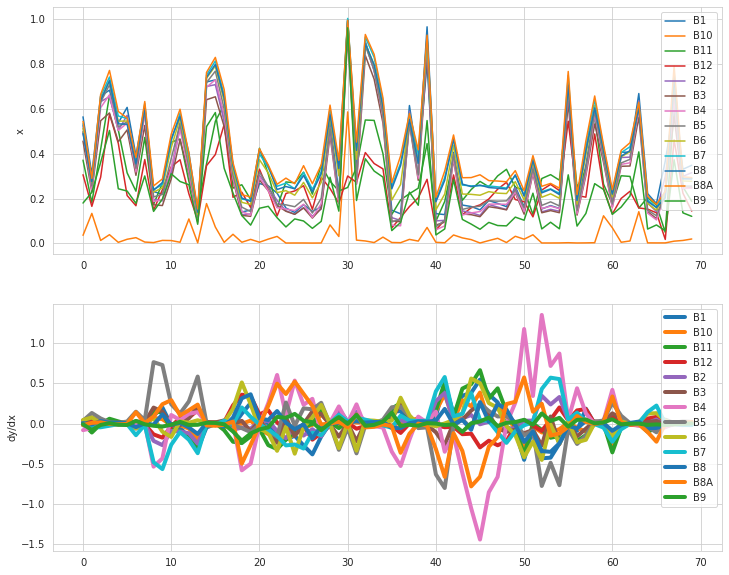

In [142]:
x_with_grad = torch.autograd.Variable(totorch(x).transpose(1,2), requires_grad=True)
logprobabilities,*_ = model.forward(x_with_grad)
maxypred = logprobabilities.exp().max()
maxypred.backward()
dydx = x_with_grad.grad

fig, axs = plt.subplots(2, figsize=(12,10))
axs[0].plot(x_with_grad[0].detach().numpy().T)
axs[0].set_ylabel("x")
axs[0].legend(BANDS)
axs[1].plot(x_with_grad.grad[0].numpy().T,linewidth=4)
axs[1].set_ylabel("dy/dx")
axs[1].legend(BANDS)

fname=os.path.join(csvdir, "msresnet", str(meta), "dydx.csv")
save_csv(dydx.numpy()[0].T,fname)
fname=os.path.join(csvdir,"msresnet", str(meta), f"x.csv")
save_csv(x,fname)

loading model from /data/isprs/backprop/tempcnn.pth
writing /home/marc/projects/ISPRS_CropTypeMapping/images/backprop/tempcnn/71460046/dydx.csv
writing /home/marc/projects/ISPRS_CropTypeMapping/images/backprop/tempcnn/71460046/x.csv


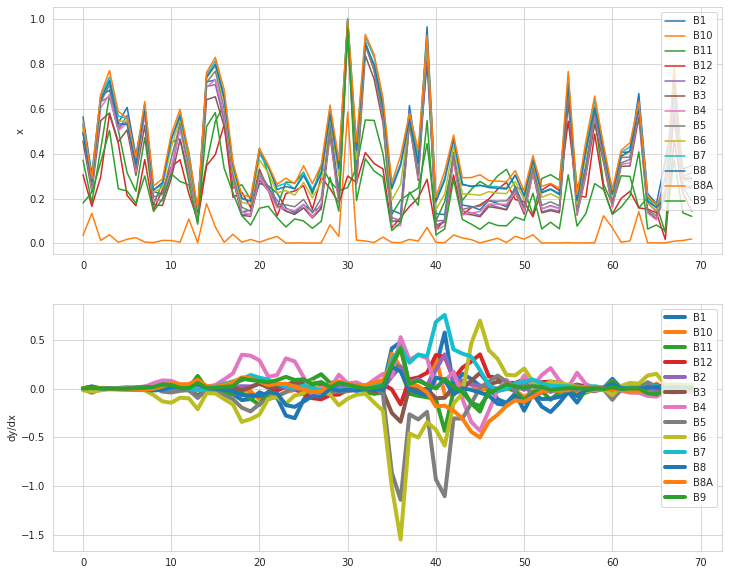

In [143]:
model = TempCNN(input_dim=13, nclasses=23, sequence_length=70)
_ = model.load("/data/isprs/backprop/tempcnn.pth")
model.eval()

x_with_grad = torch.autograd.Variable(totorch(x), requires_grad=True)
logprobabilities,*_ = model.forward(x_with_grad.transpose(1,2))
maxypred = logprobabilities.exp().max()
maxypred.backward()
dydx = x_with_grad.grad

fig, axs = plt.subplots(2, figsize=(12,10))
axs[0].plot(x_with_grad[0].detach().numpy())
axs[0].set_ylabel("x")
axs[0].legend(BANDS)
axs[1].plot(x_with_grad.grad[0].numpy(),linewidth=4)
axs[1].set_ylabel("dy/dx")
axs[1].legend(BANDS)

fname=os.path.join(csvdir, "tempcnn", str(meta), "dydx.csv")
save_csv(dydx.numpy()[0],fname)
fname=os.path.join(csvdir,"tempcnn", str(meta), f"x.csv")
save_csv(x,fname)

In [144]:
71459194

71459194